In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
df_train = None
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    if dirname == '/kaggle/input/vk-made-sports-image-classification/test':
        test_images = filenames
    elif dirname == '/kaggle/input/vk-made-sports-image-classification/train':
        train_images = filenames
    for filename in filenames:
        file = os.path.join(dirname, filename)
        if file.endswith('test.csv'):
            df_test = pd.read_csv(file)
        elif file.endswith('train.csv'):
            df_train = pd.read_csv(file)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/vk-made-sports-image-classification
/kaggle/input/vk-made-sports-image-classification/test
/kaggle/input/vk-made-sports-image-classification/train


### Libraries

I have borrowed from https://www.kaggle.com/code/elinteerie/agricultural-crop-pytorch-efficientnet-96-acc/notebook

In [2]:
import random, cv2
from tqdm import tqdm
import shutil
import time
import matplotlib.pyplot as plt
import torchvision
from torchvision import models
import torchvision.models.efficientnet as e
import torchvision.models.resnet as r
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.utils.data as data
from torchmetrics import Accuracy, Precision, F1Score
from torch.utils.data import Dataset
from PIL import Image

### Get format datasets

In [3]:
len(test_images), len(train_images), df_train.shape, df_test.shape

(19446, 45373, (45373, 2), (19446, 1))

In [4]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (300, 300)),
    torchvision.transforms.ToTensor(),
])
df_train.groupby('label').count()

,image_id
label,
alpinism,1858
archery,982
arm_wrestling,1392
badminton,1140
basketball,2519
boating,1753
boxing,1801
fencing,1421
football,2150


In [5]:
# shutil.rmtree('train_dataset')
os.mkdir('train_dataset')
ROOT_TRAIN = '/kaggle/input/vk-made-sports-image-classification/train'
for _, root in tqdm(df_train.iterrows()):
    path = os.path.join('train_dataset', root['label'])
    if os.path.isdir(path) == False:
        os.mkdir(path)
    shutil.copyfile(os.path.join(ROOT_TRAIN, root['image_id']), os.path.join(path, root['image_id']))

img_pth = '/kaggle/working/train_dataset'
datafolder = torchvision.datasets.ImageFolder(img_pth, transform=transformer)
len(datafolder)

45373it [04:09, 182.11it/s]


45373

In [6]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = all_imgs

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
img_pth = '/kaggle/input/vk-made-sports-image-classification/test'
test_set =  CustomDataSet(img_pth, transform=transformer)
classes = datafolder.classes

### Show images

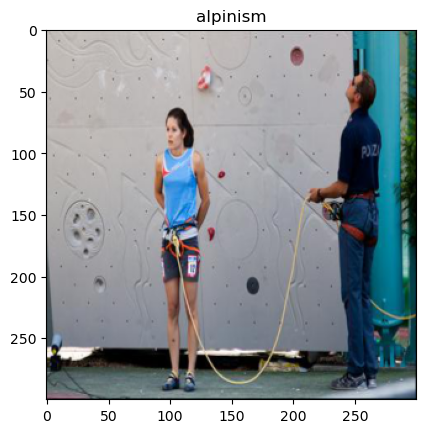

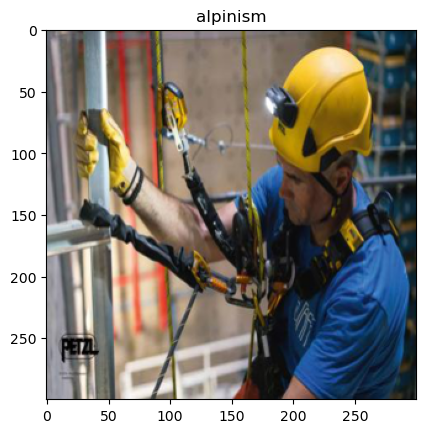

In [7]:
for i, data_ in enumerate(datafolder):
    img, label = data_
    plt.imshow(np.transpose(img, (1,2,0)))
#     plt.imshow(img_sample)
    plt.title(classes[label]);
    plt.show()
    time.sleep(1)
    if i >= 1:
        break
    

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Split dataset

In [9]:
train_set_size = int(len(datafolder) * 0.99)
valid_set_size = len(datafolder) - train_set_size
train_set, valid_set = data.random_split(datafolder, [train_set_size, valid_set_size])
len(train_set), len(valid_set)

(44919, 454)

### Load resnet and efficientnet

In [10]:
WEIGHTS = r.resnet50(pretrained= True)
WEIGHTS2 = e.efficientnet_b0(pretrained= True)
WEIGHTS.fc = nn.Linear(2048, 30)
model = WEIGHTS
model.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Set BATCH_SIZE and LOADERS

In [11]:
BATCH_SIZE = 96
train_loader = DataLoader(dataset =train_set, batch_size =BATCH_SIZE, shuffle = True)
val_loader = DataLoader(dataset= valid_set, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset=test_set)

### Set loss function and optimizer

In [12]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05).to(device) # label_smoothing=0.05
optimizer = optim.AdamW(model.parameters(), lr= 0.0001) 
accuracy_fn = Accuracy(task="multiclass", num_classes=len(classes)).to(device)
f1_fn = F1Score(task="multiclass", num_classes=len(classes), average='micro').to(device)


In [13]:
EPOCHS = 20

train_losses, train_acc, train_f1 = 0, 0, 0
model.to(device)
for epoch in range(EPOCHS):
    model.train()
    for batch, (X, y )in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        model.train()

        y_pred =model(X)
        loss = loss_fn(y_pred, y)
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        train_f1 += f1_fn(y_pred.argmax(dim=1), y)
        train_losses += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            print(f'{train_losses} | {train_f1}')
    train_losses /= len(train_loader)
    train_acc /= len(train_loader)
    train_f1 /= len(train_loader)
    print(f' Train Loss: {train_losses:.4f} | Train F1: {train_f1:.3f} | Epoch: {epoch}')

    model.eval()
    test_loss, test_acc, test_f1 = 0, 0, 0
    with torch.inference_mode():
        for Xt, yt in val_loader:
            Xt = Xt.to(device)
            yt= yt.to(device)
            test_pred = model(X)
            t_loss = loss_fn(test_pred, y)
            test_loss += t_loss
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
            test_f1 += f1_fn(test_pred.argmax(dim=1), y)
        test_loss /= len(val_loader)
        test_acc /= len(val_loader)
        test_f1 /= len(val_loader)

        print(f' Test Loss {test_loss:.4f} | Test F1: {test_f1:.2f}   ')
    torch.save(model,f'model_{BATCH_SIZE}_300_e{epoch}_l_{test_loss:.4f}_f1_{test_f1:.2f}.pkl')

3.468090295791626 | 0.010416666977107525
 Train Loss: 0.9431 | Train F1: 0.840 | Epoch: 0
 Test Loss 0.6689 | Test F1: 0.90   
1.5941295623779297 | 1.7460596561431885
 Train Loss: 0.5797 | Train F1: 0.949 | Epoch: 1
 Test Loss 0.6375 | Test F1: 0.94   
1.0743231773376465 | 1.9172651767730713
 Train Loss: 0.4653 | Train F1: 0.983 | Epoch: 2
 Test Loss 0.4482 | Test F1: 0.98   
0.8691556453704834 | 1.9834375381469727
 Train Loss: 0.4133 | Train F1: 0.997 | Epoch: 3
 Test Loss 0.4133 | Test F1: 0.99   
0.8062611222267151 | 1.9965128898620605
 Train Loss: 0.3895 | Train F1: 1.001 | Epoch: 4
 Test Loss 0.3780 | Test F1: 1.00   
0.7707414627075195 | 2.000638484954834
 Train Loss: 0.3795 | Train F1: 1.001 | Epoch: 5
 Test Loss 0.3751 | Test F1: 1.00   
0.7546244859695435 | 2.001492977142334
 Train Loss: 0.3760 | Train F1: 1.002 | Epoch: 6
 Test Loss 0.3676 | Test F1: 1.00   
0.7463171482086182 | 2.0018062591552734
 Train Loss: 0.3801 | Train F1: 1.001 | Epoch: 7
 Test Loss 0.3972 | Test F1: 1

### Evaluate model

In [14]:
model.to(device)
model.eval()
preds_list = []
with torch.inference_mode():
    for i, X_test in tqdm(enumerate(test_loader)):
        X_test = X_test.to(device)
        img = test_loader.dataset.total_imgs[i]
        test_pred = model(X_test)
        preds_list.append(test_pred.argmax(dim=1))



19446it [05:22, 60.34it/s]


### Get submission

In [15]:
pred_d = {}
for i, data_ in enumerate(test_set):
    img = data_
    label = i
    pred_d[test_set.total_imgs[i]] = classes[preds_list[label]]
df_test['label'] = df_test['image_id'].map(pred_d)  
df_test.to_csv('submission_12.csv', index=False)

### Check correctness

66f867a8-796c-4e3e-84ad-b55b60d0742d.jpeg


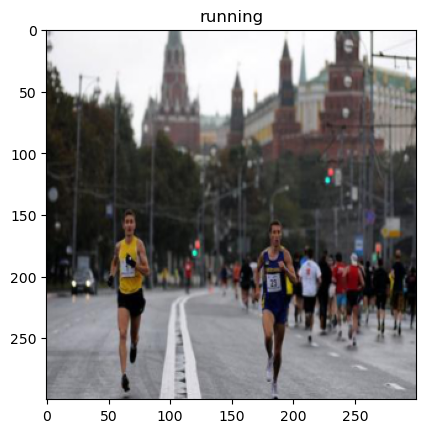

63c1f328-be56-4ada-b709-c14a1230189f.jpeg


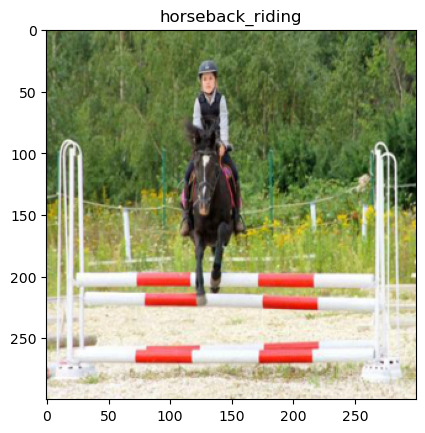

a3237adb-e5fe-4ea4-b258-588c06235319.jpeg


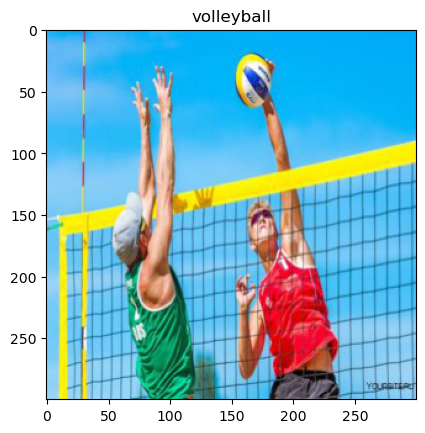

396648f9-7486-44cb-aa3d-ae62627e414d.jpeg


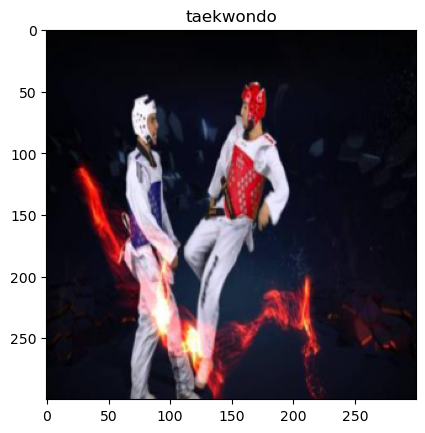

a5a17d4b-69e8-42e4-9461-ff37cebc68e9.jpeg


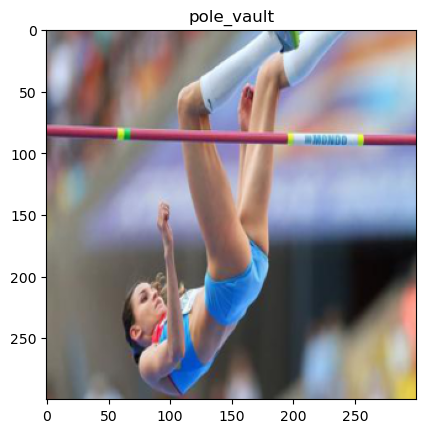

a76c8096-0ee7-4148-ba7b-16ab0e6d558b.jpeg


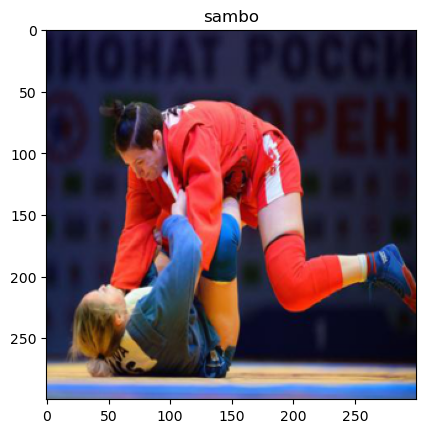

71747827-9aa8-4ff0-8ad0-41146fcdf928.jpeg


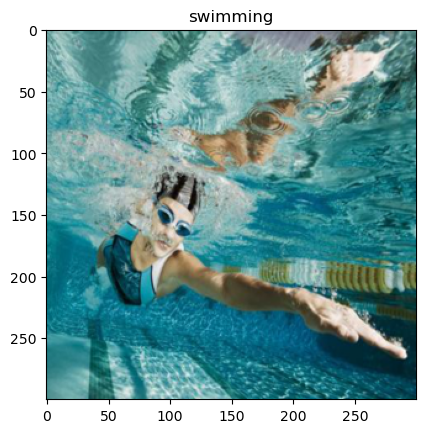

In [16]:
for i, data_ in enumerate(test_set):
    img = data_
    plt.imshow(np.transpose(img, (1,2,0)))
    label = i
    plt.title(classes[preds_list[label]]);
    print(test_set.total_imgs[i])
    plt.show()
    if i > 5:
        break